## Customer Experience Insights from Car Reviews

We will extract insights from car reviews using the following steps:

- Load the data
- Clean the data
- Extract insights from the data using LLMs and Langchain

In [1]:
from datasets import load_dataset

dataset = load_dataset("florentgbelidji/car-reviews")

d:\Anaconda\envs\llms\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset csv (C:/Users/Subha/.cache/huggingface/datasets/florentgbelidji___csv/florentgbelidji--car-reviews-eddb0c58c5c9c7fa/0.0.0/6954658bab30a358235fa864b05cf819af0e179325c740e4bc853bcc7ec513e1)
100%|██████████| 1/1 [00:00<00:00, 142.85it/s]


In [35]:
from dotenv import load_dotenv,find_dotenv

load_dotenv(find_dotenv())

True

In [3]:
# List the dataset as a dataframe and show some sample data
import pandas as pd
# Max rows and columns to display
pd.set_option('display.max_rows', 50)
pd.set_option('display.max_columns', 1000)

# Drop the unnamed columns
df = pd.DataFrame(dataset['train']).drop(columns=['Unnamed: 0','Unnamed: 0.1'])
df.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating
0,on 02/02/17 19:53 PM (PST),Ricardo,1997 Toyota Previa Minivan LE 3dr Minivan,"great vehicle, Toyota best design ever. thank you","there is no way back, enjoy what you have .",5
1,on 12/17/16 16:40 PM (PST),matt,1997 Toyota Previa Minivan LE All-Trac 3dr Min...,"my 4th previa, best van ever made!",1st 95 went over 300k before being totalled b...,5
2,on 04/14/10 07:43 AM (PDT),Joel G,1997 Toyota Previa Minivan LE 3dr Minivan,Mom's Taxi Babies Ride,Sold 86 Toyota Van 285K miles to be replaced ...,5
3,on 11/12/08 17:31 PM (PST),Dennis,1997 Toyota Previa Minivan LE All-Trac 3dr Min...,My Favorite Van Ever,"I have owned lots of vans, and the Previa is ...",5
4,on 04/14/08 22:47 PM (PDT),Alf Skrastins,1997 Toyota Previa Minivan LE All-Trac 3dr Min...,Best Minivan ever,My 1997 AWD Previa is the third one that I ha...,5


In [4]:
df.shape

(36984, 6)

In [5]:
# Cleanup the data
df = df.dropna()
# lowercase all string type columns
df = df.applymap(lambda s:s.lower() if type(s) == str else s)
# Check the value counts of the Vehicle_Title column and print the top 20
df['Vehicle_Title'].value_counts()[:20]

Vehicle_Title
2007 bmw x3 suv 3.0si 4dr suv awd (3.0l 6cyl 6m)                                 70
2008 toyota camry hybrid sedan 4dr sedan (2.4l 4cyl gas/electric hybrid cvt)     70
2007 toyota camry hybrid sedan 4dr sedan (2.4l 4cyl gas/electric hybrid cvt)     70
2006 toyota prius hatchback 4dr hatchback (1.5l 4cyl gas/electric hybrid cvt)    70
2004 toyota prius hatchback 4dr hatchback (1.5l 4cyl cvt)                        70
2005 toyota prius hatchback 4dr hatchback (1.5l 4cyl gas/electric hybrid cvt)    70
2009 toyota camry hybrid sedan 4dr sedan (2.4l 4cyl gas/electric hybrid cvt)     70
2002 toyota prius sedan 4dr sedan (1.5l 4cyl gas/electric hybrid cvt)            66
2002 toyota mr2 spyder convertible 2dr convertible (1.8l 4cyl 5m)                59
2003 nissan sentra se-r spec v se-r spec v 4dr sedan (2.5l 4cyl 6m)              59
2010 nissan maxima sedan 3.5 sv 4dr sedan (3.5l 6cyl cvt)                        57
2002 nissan sentra se-r spec v se-r spec v 4dr sedan (2.5l 4cy

In [6]:
# Which vehicle titles have the most rating of 3 or less?
df[df['Rating'] <= 4]['Vehicle_Title'].value_counts()[:20]

Vehicle_Title
2008 nissan altima sedan 2.5 s 4dr sedan (2.5l 4cyl cvt)                         37
2006 nissan sentra sedan 1.8 s 4dr sedan (1.8l 4cyl 4a)                          35
2007 bmw x3 suv 3.0si 4dr suv awd (3.0l 6cyl 6m)                                 34
2007 nissan altima sedan 2.5 s 4dr sedan (2.5l 4cyl cvt)                         30
2006 nissan maxima sedan 3.5 se 4dr sedan (3.5l 6cyl 5a)                         30
2002 nissan sentra se-r spec v se-r spec v 4dr sedan (2.5l 4cyl 6m)              30
2002 nissan sentra se-r se-r 4dr sedan (2.5l 4cyl 5m)                            30
2010 toyota corolla sedan le 4dr sedan (1.8l 4cyl 4a)                            28
2000 nissan sentra sedan gxe 4dr sedan                                           28
2007 toyota prius hatchback 4dr hatchback (1.5l 4cyl gas/electric hybrid cvt)    27
1999 toyota camry sedan le 4dr sedan                                             27
2008 nissan sentra sedan 2.0 s 4dr sedan (2.0l 4cyl cvt)      

`pro-tip`: You can use some clustering techniques to group the reviews of the same car model together. This will help you to extract insights from the reviews of the same car model.

For this notebook, we will however focus on extracting insights from the reviews of `2008 nissan altima sedan 2.5 s 4dr sedan (2.5l 4cyl cvt)`.

In [7]:
nissan_altima_data = df[df['Vehicle_Title'] == '2008 nissan altima sedan 2.5 s 4dr sedan (2.5l 4cyl cvt)']
nissan_altima_data.head()

,Review_Date,Author_Name,Vehicle_Title,Review_Title,Review,Rating
33271,on 07/26/18 05:33 am (pdt),mick w.,2008 nissan altima sedan 2.5 s 4dr sedan (2.5l...,where do i start with complaints?,"the cvt transmission failed at 120,000 which ...",1
33273,on 05/29/18 08:55 am (pdt),r lyons,2008 nissan altima sedan 2.5 s 4dr sedan (2.5l...,screwed the widow woman,"bought it used, knew the owner , 1 owner, wel...",2
33274,on 07/16/17 05:03 am (pdt),mtnhiker70,2008 nissan altima sedan 2.5 s 4dr sedan (2.5l...,good car except for the cvt,the car drive nicely and i've owned it for 9 ...,4
33276,on 03/27/17 22:09 pm (pdt),bill,2008 nissan altima sedan 2.5 s 4dr sedan (2.5l...,will never buy the cvt transmission again,i had a 2003 nissan altima 2.5 sl that i love...,3
33278,on 01/18/17 20:39 pm (pst),jtab,2008 nissan altima sedan 2.5 s 4dr sedan (2.5l...,own 2 of them same year and model,both cars have reached over 110k. reliability...,3


In [8]:
nissan_altima_data.Rating.value_counts()

Rating
4    21
3    12
5     9
2     3
1     1
Name: count, dtype: int64

In [9]:
# Combine the review title and review text into a single column
nissan_altima_data['Review_Text'] = nissan_altima_data['Review_Title'] + ' ' + nissan_altima_data['Review']

C:\Users\Subha\AppData\Local\Temp\ipykernel_3780\2622127119.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nissan_altima_data['Review_Text'] = nissan_altima_data['Review_Title'] + ' ' + nissan_altima_data['Review']


C:\Users\Subha\AppData\Local\Temp\ipykernel_3780\2174168981.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  nissan_altima_data['Review_Text_Word_Count'] = nissan_altima_data['Review_Text'].apply(lambda x: len(x.split()))
C:\Users\Subha\AppData\Local\Temp\ipykernel_3780\2174168981.py:10: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(nissan_altima_data['Review_Text_Word_Count'], kde=True)


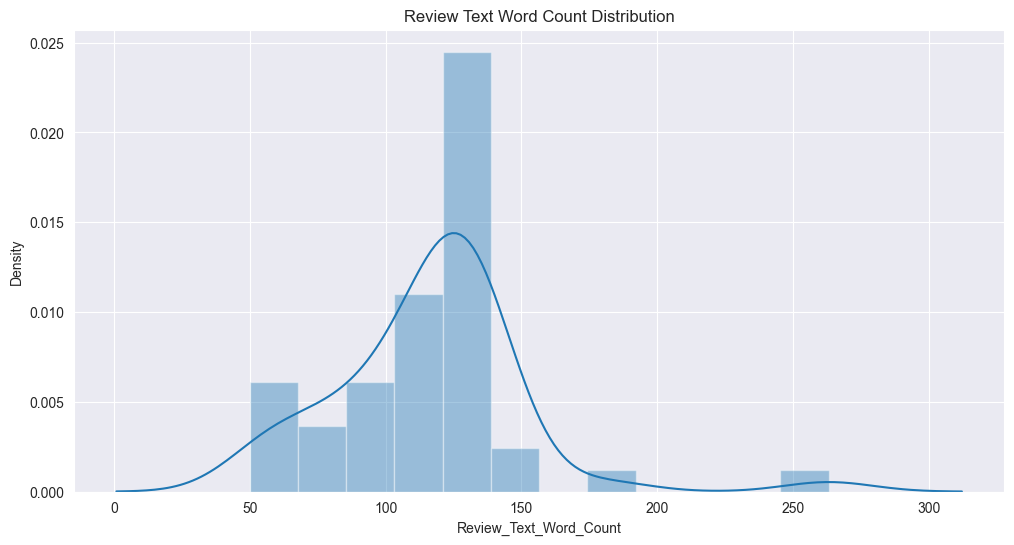

In [10]:
# Calculate the number of words in the review text
nissan_altima_data['Review_Text_Word_Count'] = nissan_altima_data['Review_Text'].apply(lambda x: len(x.split()))

# Plot the distribution of the review text word count
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

plt.figure(figsize=(12,6))
sns.distplot(nissan_altima_data['Review_Text_Word_Count'], kde=True)
plt.title('Review Text Word Count Distribution')
plt.show()

In [11]:
from langchain.embeddings import HuggingFaceHubEmbeddings
embeddings = HuggingFaceHubEmbeddings(repo_id="sentence-transformers/all-MiniLM-L6-v2")

# # Create a dataframe with the review text and the embeddings
# nissan_altima_data['Review_Text_Embeddings'] = nissan_altima_data['Review_Text'].apply(lambda x: embeddings.embed_query(x))

You're using a different task than the one specified in the repository. Be sure to know what you're doing :)


In [12]:
# # Create a Chroma DB and add the review text embeddings
# from langchain.vectorstores import Chroma


# db = Chroma(embedding_function=embeddings.embed_query)
# db.add_vectors(nissan_altima_data['Review_Text_Embeddings'].tolist())

In [13]:
import pinecone
from langchain.vectorstores import Pinecone
import os
# Initialize Pinecone
pinecone.init(api_key = os.getenv("PINECONE_API_KEY"),
                environment = os.getenv("PINECONE_ENV")
)

In [14]:
vstore = Pinecone.from_texts(nissan_altima_data['Review_Text'].tolist(), embeddings, index_name='car-reviews')

In [15]:
query = "Good engine, but the transmission is not good."
result = vstore.similarity_search(query)
result

[Document(page_content="good car except for the cvt  the car drive nicely and i've owned it for 9 years, 100k and done just tires and brakes. but i've had major problems with the cvt.  it's been warranteed by nissan.  the transmission died on a long trip last summer.  thankfully it was still under the recall warranty.  but it could have caused an accident and we left stranded 3 states away from home.  a dealership in nj fixed it and the tranny is much better now.", metadata={}),
 Document(page_content="good car except for the cvt  the car drive nicely and i've owned it for 9 years, 100k and done just tires and brakes. but i've had major problems with the cvt.  it's been warranteed by nissan.  the transmission died on a long trip last summer.  thankfully it was still under the recall warranty.  but it could have caused an accident and we left stranded 3 states away from home.  a dealership in nj fixed it and the tranny is much better now.", metadata={}),
 Document(page_content="screwed 

### RetrievalQA LLM Chain

In [50]:
from langchain.chains import RetrievalQA
from langchain import HuggingFaceHub
from langchain.chat_models import ChatOpenAI

# initialize Hub LLM
llm = HuggingFaceHub(
        repo_id='declare-lab/flan-alpaca-base',
    model_kwargs={'temperature':1e-10}
)

# llm = ChatOpenAI(model_name="gpt-3.5-turbo",temperature=0.0,openai_api_key=os.getenv("OPENAI_API_KEY"))

review_qa_chain = RetrievalQA.from_chain_type(
    chain_type='stuff',
    llm=llm,
    retriever=vstore.as_retriever(),
)

In [53]:
prompt_template = "Below is an instruction that describes a task. Write a response that appropriately completes the request.\n\n### Instruction:\n{instruction}\n\n### Response:"


# q = """
# The reviews are for the car model: 2008 nissan altima sedan 2.5 s 4dr sedan (2.5l 4cyl cvt)'.
# What is the overall impression of these reviews? Give most prevalent examples in bullets. 
# What do you suggest the manufacturer must focus on improving?
# """
q = """
The reviews are for the car model: 2008 nissan altima sedan 2.5 s 4dr sedan (2.5l 4cyl cvt)'.
Can you summarize reviews?
"""
prompt = prompt_template.format(instruction=q)

result = review_qa_chain.run(prompt)
result


"I'm glad you found this helpful."